In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
casa = True
test = False

In [4]:
if not test:
    from dask.distributed import Client
    
    if 'client' not in locals() or client is None:
        from coffea_casa import CoffeaCasaCluster
        cluster = CoffeaCasaCluster(memory="10 GiB", dashboard_port=2211, scheduler_options={ "dashboard_address": 2212})
        cluster.adapt(minimum=0, maximum=100)
        client = Client(cluster)
        print("✅ Dask client created and connected.")
    else:
        print("ℹ️ Dask client already exists.")
    if casa:
        import shutil, os, pathlib
    
        pkg_dir = pathlib.Path("/home/cms-jovyan/new_git/zjet_corrections/src/zjet_corrections")   # or the actual path to your package dir
        zip_path = pathlib.Path("/tmp/zjet_corrections.zip")
        if zip_path.exists():
            zip_path.unlink()
        shutil.make_archive(zip_path.with_suffix(""), "zip", pkg_dir.parent, pkg_dir.name)
    
        client.upload_file(str(zip_path))  # uploads the zip and adds it to workers' sys.path
    else:
        # client is already defined above, so nothing needs to be done here
        client = None
else:
    print("Running locally with 1-2 files")
    client = None


{'memory': '10 GiB', 'protocol': 'tls://', 'security': Security(require_encryption=True, tls_ca_file=Local (/etc/cmsaf-secrets/ca.pem), tls_client_cert=Local (/etc/cmsaf-secrets/hostcert.pem), tls_client_key=Local (/etc/cmsaf-secrets/hostcert.pem), tls_min_version=771, tls_scheduler_cert=Local (/etc/cmsaf-secrets/hostcert.pem), tls_scheduler_key=Local (/etc/cmsaf-secrets/hostcert.pem), tls_worker_cert=Local (/etc/cmsaf-secrets/hostcert.pem), tls_worker_key=Local (/etc/cmsaf-secrets/hostcert.pem)), 'log_directory': 'logs', 'silence_logs': 'DEBUG', 'scheduler_options': {'port': 8786, 'dashboard_address': '2211', 'protocol': 'tls', 'contact_address': 'tls://aritra-2emandal-40cern-2ech.dask.cmsaf-prod.flatiron.hollandhpc.org:8786'}, 'job_extra_directives': {'universe': 'docker', 'docker_image': 'hub.opensciencegrid.org/coffea-casa/cc-analysis-alma9:2025.05.24', 'container_service_names': 'dask,nanny', 'dask_container_port': 8786, 'nanny_container_port': 8001, 'use_x509userproxy': False, 't

2025-11-13 22:43:45,863 - distributed.scheduler - INFO - State start
2025-11-13 22:43:45,867 - distributed.scheduler - INFO - Closing scheduler. Reason: failure-to-start-<class 'OSError'>
2025-11-13 22:43:45,868 - distributed.scheduler - INFO - Scheduler closing all comms


ValueError: cannot get address of non-running Server

In [5]:
# from importlib.resources import files

# data_root = files("zjet_corrections") / "corrections" / "pu"
# print(any(p.name == "puWeights.json.gz" for p in data_root.rglob("puWeights.json.gz")))


In [6]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent)+'/src')  # add ".." to import path

In [7]:
from zjet_corrections.corrections import debug_jec_weightset
debug_jec_weightset('2018', mode='AK8', is_data=False)

{'path': '/tmp/tmpvn9ndvss/Summer19UL18_V5_MC_L1FastJet_AK8PFPuppi.jec.txt',
 'resource_exists': True,
 'evaluator_keys': ['Summer19UL18_V5_MC_L1FastJet_AK8PFPuppi']}

In [8]:
import coffea
import numpy as np
import awkward as ak
from dask.distributed import Client
import uproot
import pickle
import os, sys, subprocess, json, gzip, correctionlib
import time
#sys.path.append(os.path.join(os.getcwd(), "src/zjet_corrections"))
import sys, os
sys.path.insert(0, os.path.abspath("/work")) 
import importlib
#zjet_corrections = _ensure_import("zjet_corrections")
import zjet_corrections.zjet_processor

importlib.reload(zjet_corrections.zjet_processor)

from zjet_corrections.zjet_processor import QJetMassProcessor
from coffea.nanoevents import NanoAODSchema
from coffea import processor


In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
def format_time(seconds):
    hours, remainder = divmod(int(seconds), 3600)
    minutes, seconds = divmod(remainder, 60)
    if hours:
        return f"{hours}h {minutes}m {seconds}s"
    elif minutes:
        return f"{minutes}m {seconds}s"
    else:
        return f"{seconds}s"

In [11]:
NanoAODSchema.warn_missing_crossrefs = False



def make_runner(
    use_dask: bool = False,
    client=None,
    workers: int = 1,
    chunksize: int = 200_000,
    maxchunks: int | None = 1,
    skipbadfiles: bool = True,
):
    """
    If use_dask=True, 'client' must be an existing distributed.Client.
    Otherwise falls back to FuturesExecutor(workers=...).
    """
    if use_dask:
        if client is None:
            raise ValueError("use_dask=True but no Dask 'client' was provided.")
        executor = processor.DaskExecutor(
            client=client,
            status=True,      # progress bar
            retries=3,        # re-try failed chunks
            treereduction = 4
        )
    else:
        executor = processor.FuturesExecutor(
            workers=workers,
            status=True,      # progress bar
            compression=None, # keep your original choice
        )

    return processor.Runner(
        executor=executor,
        schema=NanoAODSchema,
        chunksize=chunksize,
        maxchunks=maxchunks,
        skipbadfiles=skipbadfiles,
    )

# -------------------------
# Usage (Futures locally):
# -------------------------
# run = make_runner(use_dask=False, workers=1, chunksize=100000, maxchunks=None)
# out = run(fileset, "Events", processor_instance=ZmmMinimal())

In [12]:
print(zjet_corrections.__file__)

/home/cms-jovyan/new_git/zjet_corrections/src/zjet_corrections/__init__.py


In [13]:
data = False
dataset = 'pythia' #st or pythia
#dataset = 'st'

In [14]:
ht_bins = ['100to200',  '200to400', '400to600', '600to800', '800to1200', '1200to2500','2500toInf']

In [15]:
# if data:
#     sample_path = ['SingleMuon_UL2018.txt', 'EGamma_UL2018.txt',]
#                    #'SingleMuon_UL2017.txt', 'SingleElectron_UL2017.txt',
#                     #       'SingleMuon_UL2016APV.txt', 'SingleElectron_UL2016APV.txt','SingleMuon_UL2016.txt', 'SingleElectron_UL2016.txt']
# else:
#     if pythia:
#         sample_path = ['pythia_UL16NanoAODAPVv9_files.txt',
#                        'pythia_UL16NanoAODv9_files.txt',
#                        'pythia_UL17NanoAODv9_files.txt',
#                        'pythia_UL18NanoAODv9_files.txt']
                       

In [16]:
prependstr = 'root://xcache/'
if data:    
    #prependstr = "root://cmsxrootd.fnal.gov/"
    if casa:
        sample_path = [
                        'SingleMuon_UL2018.txt', 'EGamma_UL2018.txt',]
                        #'SingleMuon_UL2017.txt', 'SingleElectron_UL2017.txt',]
                        #'SingleMuon_UL2016APV.txt', 'SingleElectron_UL2016APV.txt',
                        #'SingleMuon_UL2016.txt', 'SingleElectron_UL2016.txt']
                   # ]
    else:
        sample_path = '/work/ws/zjet_corrections/tests/samples.txt'
    
    fileset = {}
    for path in sample_path:
        sample = path.split('.')[0]
        with open('samples/' + path) as f:
            lines = f.readlines()
        
        files = []
        for line in lines:
            files.append(prependstr + line[:-1])
        fileset[sample] = files
else:
    prependstr = 'root://xcache/'
    
    #prependstr = "root://cmsxrootd.fnal.gov/"
    if casa:
        if dataset == 'pythia':
            sample_path = [#'pythia_UL16NanoAODAPVv9.txt',]
                       'pythia_UL16NanoAODv9.txt',]
                       #'pythia_UL17NanoAODv9.txt',]
                       #'pythia_UL18NanoAODv9.txt']
            fileset = {}
            for path in sample_path:
                sample = path.split('.')[0]
                print('samples_mc/' + path)
                with open('samples_mc/' + path) as f:
                    lines = f.readlines()
                
                
                for ht_bin in ht_bins:
                    files = []
                    for line in lines:
                        if ht_bin in line:
                            files.append(prependstr + line[:-1])
                    fileset[sample + '_HT-' + ht_bin] = files
        elif dataset == 'herwig':
                sample_path = ['herwig7_UL16NanoAODAPVv9_inclusive.txt',
                           'herwig7_UL16NanoAODv9_inclusive.txt',
                           'herwig7_UL17NanoAODv9_inclusive.txt',
                           'herwig7_UL18NanoAODv9_inclusive.txt']
                fileset = {}
                for path in sample_path:
                    sample = path.split('.')[0]
                    print('samples_mc/' + path)
                    with open('samples_mc/' + path) as f:
                        lines = f.readlines()
    
                    files = []
                    for line in lines:
                        files.append(prependstr + line[:-1])
                    fileset[sample] = files
        elif dataset == 'powheg':
                sample_path = [
                           #'herwig7_UL16NanoAODAPVv9_inclusive.txt',
                           #'herwig7_UL16NanoAODv9_inclusive.txt',
                          # 'herwig7_UL17NanoAODv9_inclusive.txt',
                           'powheg_UL18NanoAODv9_inclusive.txt'
                            ]
                fileset = {}
                for path in sample_path:
                    sample = path.split('.')[0]
                    print('samples_mc/' + path)
                    with open('samples_mc/' + path) as f:
                        lines = f.readlines()
    
                    files = []
                    for line in lines:
                        files.append(prependstr + line[:-1])
                    fileset[sample] = files
        elif dataset == 'st':
            sample_path = [
                            'st_tW_antitop_UL16NanoAODv9.txt',
                            'st_tW_antitop_UL16NanoAODAPVv9.txt',
                            'st_tW_antitop_UL17NanoAODv9.txt',
                            'st_tW_antitop_UL18NanoAODv9.txt',
                            'st_tW_top_UL16NanoAODv9.txt',
                            'st_tW_top_UL16NanoAODAPVv9.txt',
                            'st_tW_top_UL17NanoAODv9.txt',
                            'st_tW_top_UL18NanoAODv9.txt',
                            'ST_t-channel_antitop_4f_InclusiveDecays_UL16NanoAODv9.txt',
                            'ST_t-channel_antitop_4f_InclusiveDecays_UL16NanoAODAPVv9.txt',
                            'ST_t-channel_antitop_4f_InclusiveDecays_UL17NanoAODv9.txt',
                            'ST_t-channel_antitop_4f_InclusiveDecays_UL18NanoAODv9.txt',
                            'ST_t-channel_top_4f_InclusiveDecays_UL16NanoAODv9.txt',
                            'ST_t-channel_top_4f_InclusiveDecays_UL16NanoAODAPVv9.txt',
                            'ST_t-channel_top_4f_InclusiveDecays_UL17NanoAODv9.txt',
                            'ST_t-channel_top_4f_InclusiveDecays_UL18NanoAODv9.txt',
                            ]     
            fileset = {}
            for path in sample_path:
                sample = path.split('.')[0]
                print('samples_mc/' + path)
                with open('samples_mc/' + path) as f:
                    lines = f.readlines()

                files = []
                for line in lines:
                    files.append(prependstr + line[:-1])
                fileset[sample] = files
                            

samples_mc/pythia_UL16NanoAODv9.txt


In [17]:
print(fileset.keys())

# systematics = ['nominal']
# jet_systematics = ['nominal']#, 'JERUp']

systematics = None
jet_systematics = None



dict_keys(['pythia_UL16NanoAODv9_HT-100to200', 'pythia_UL16NanoAODv9_HT-200to400', 'pythia_UL16NanoAODv9_HT-400to600', 'pythia_UL16NanoAODv9_HT-600to800', 'pythia_UL16NanoAODv9_HT-800to1200', 'pythia_UL16NanoAODv9_HT-1200to2500', 'pythia_UL16NanoAODv9_HT-2500toInf'])


In [18]:
#fileset_test = {"DYJets":["/work/ws/zjet_corrections/tests/DYjets.root"]}
importlib.reload(zjet_corrections)
if casa:
    fileset_test = {list(fileset.keys())[2]:[fileset[list(fileset.keys())[3]][3]]}

else:
    fileset_test = {"DYJets":["/work/ws/zjet_corrections/tests/DYjets.root"]}

if test:
    run = make_runner(use_dask=False, client=client, chunksize=1000, maxchunks=1)
    t0 = time.time()
    out = run(fileset_test, "Events", processor_instance=QJetMassProcessor(do_gen = not data,
                                                                      debug=True,
                                                                      systematics = systematics,
                                                                      jet_systematics = jet_systematics)
         )
else:
    run = make_runner(use_dask=True, client=client, chunksize=50000, maxchunks=None)
    t0 = time.time()
    out = run(fileset, "Events", processor_instance=QJetMassProcessor(do_gen = not data,
                                                                      debug=True,
                                                                      systematics = systematics,
                                                                      jet_systematics = jet_systematics)
         )
t1 = time.time()
print(f"Done Running, time taken {format_time(t1 - t0)}")

NameError: name 'client' is not defined

In [18]:
client.close()

In [ ]:
# import pickle
# with open('herwig_ht_LO_output.pkl', "wb") as f:
#     pickle.dump(out, f)


import pickle
fout = 'pythia_16_syst.pkl'
#fout = 'dasd_output_syst.pkl'
with open(fout, "wb") as f:
    pickle.dump(out, f)
import os
size = os.path.getsize(fout)
unit = "kB" if size < 1e6 else "MB"
value = size / (1e3 if unit == "kB" else 1e6)
print(f"Output written to {fout} with size {value:.1f} {unit}")


In [19]:
# import pickle
# with open('pythia_ht_LO_output.pkl', "wb") as f:
#     pickle.dump(out, f)
# print(f"Output written to test_output.pkl with size {os.path.getsize('pythia_ht_LO_output.pkl')/1e6:.1f} MB")


In [20]:
client.close()

/tmp/ipykernel_6820/3339354576.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


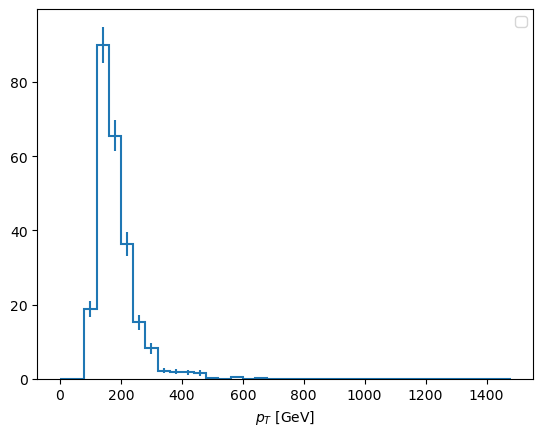

In [23]:
import matplotlib.pyplot as plt
import hist
out['ptz_mz_reco'].project('pt')[hist.rebin(4)].plot(stack = False)
plt.legend()

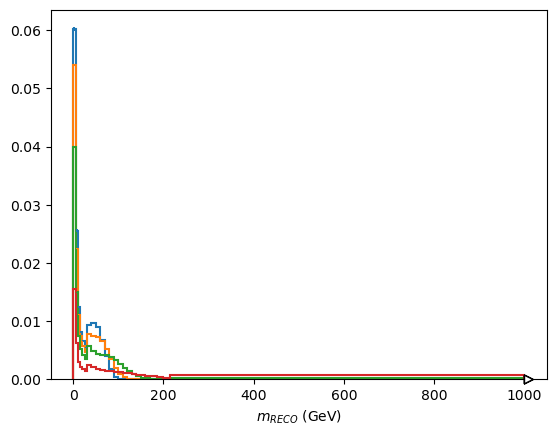

In [27]:
for i in range(4):
    out['ptjet_mjet_g_reco'][{'systematic':'nominal'}].project('ptreco','mreco')[i,:].plot(density = True)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f13928035b0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

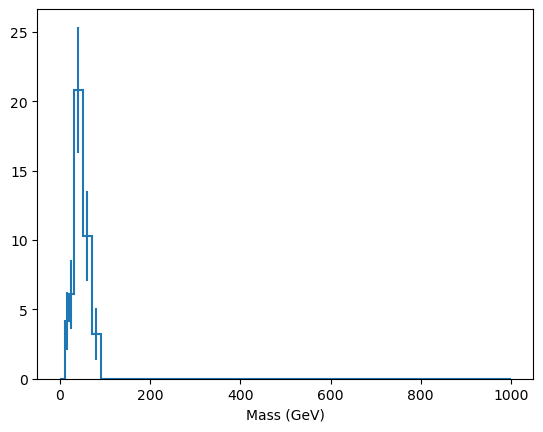

In [23]:
import hist
out['ptjet_mjet_u_gen'][{"systematic":"nominal"}].project('ptgen','mgen')[0,hist.rebin(1)].plot(label='Truth')

(0.0, 200.0)

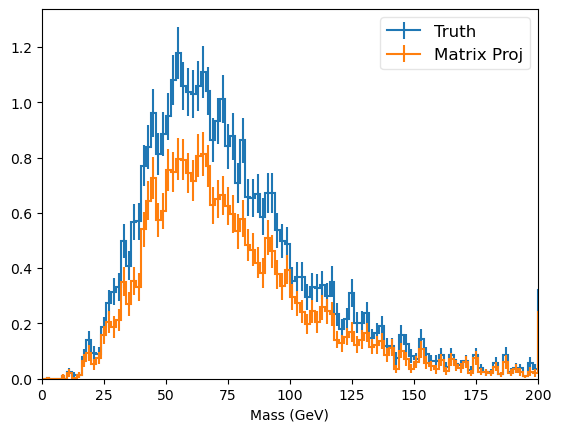

In [23]:
import hist
import matplotlib.pyplot as plt
h1 = out['ptjet_mjet_u_gen'][{"systematic":"nominal"}].project('ptgen','mgen')[2,hist.rebin(1)]
h2 = out['response_matrix_u'][{"systematic":"nominal"}].project('ptgen','mgen')[2,hist.rebin(1)]
h1.plot(label='Truth')
h2.plot(label='Matrix Proj')
plt.legend()
total_reco = h1.sum().value
total_gen = h2.sum().value
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
new_labels = []
for lab in labels:
    if lab == 'Reco':
        new_labels.append(f"Reco (Total: {total_reco:.0f})")
    elif lab == 'Gen':
        new_labels.append(f"Gen (Total: {total_gen:.0f})")
    else:
        new_labels.append(lab)
ax.legend(handles, new_labels, loc='best', fontsize=12, framealpha=0.5)
#plt.yscale('log')
plt.xlim(0,200)

(0.5, 1.5)

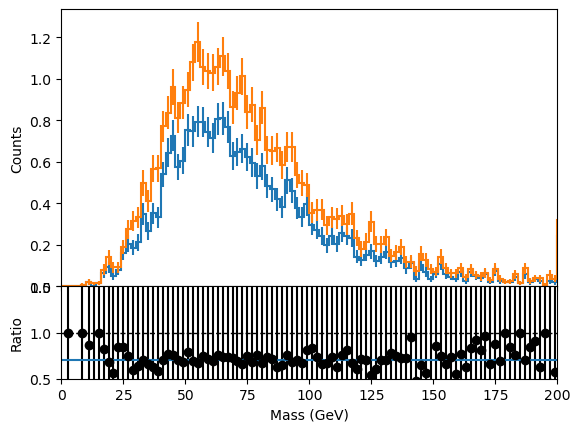

In [24]:
h2.plot_ratio(h1)
plt.xlim(0,200)
plt.hlines([0.7], 0, 200)
plt.ylim(0.5,1.5)

(0.0, 200.0)

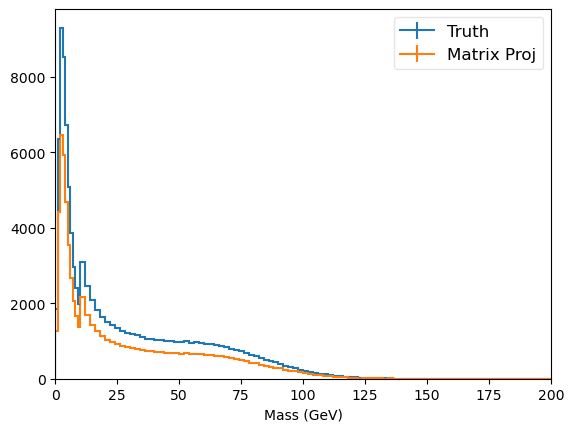

In [89]:
import hist
import matplotlib.pyplot as plt
h1 = out['ptjet_mjet_g_gen'][{"systematic":"nominal"}].project('ptgen','mgen')[0,hist.rebin(1)]
h2 = out['response_matrix_g'][{"systematic":"nominal"}].project('ptgen','mgen')[0,hist.rebin(1)]
h1.plot(label='Truth')
h2.plot(label='Matrix Proj')
plt.legend()
total_reco = h1.sum().value
total_gen = h2.sum().value
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
new_labels = []
for lab in labels:
    if lab == 'Reco':
        new_labels.append(f"Reco (Total: {total_reco:.0f})")
    elif lab == 'Gen':
        new_labels.append(f"Gen (Total: {total_gen:.0f})")
    else:
        new_labels.append(lab)
ax.legend(handles, new_labels, loc='best', fontsize=12, framealpha=0.5)
#plt.yscale('log')
plt.xlim(0,200)

(0.5, 1.5)

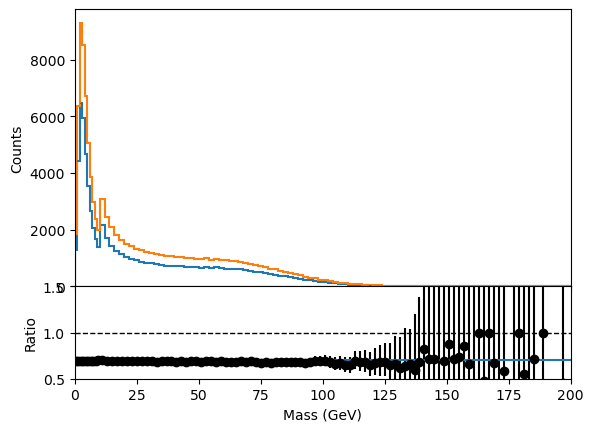

In [90]:
h2.plot_ratio(h1)
plt.xlim(0,200)
plt.hlines([0.7], 0, 200)
plt.ylim(0.5,1.5)

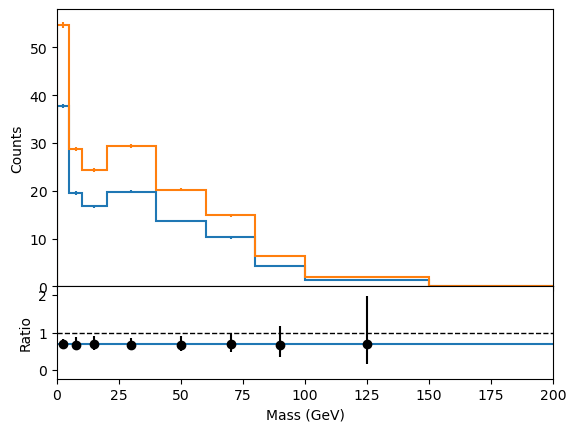

In [27]:
h2.plot_ratio(h1)
plt.xlim(0,200)
plt.hlines([0.7], 0, 200)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fddc4059690>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

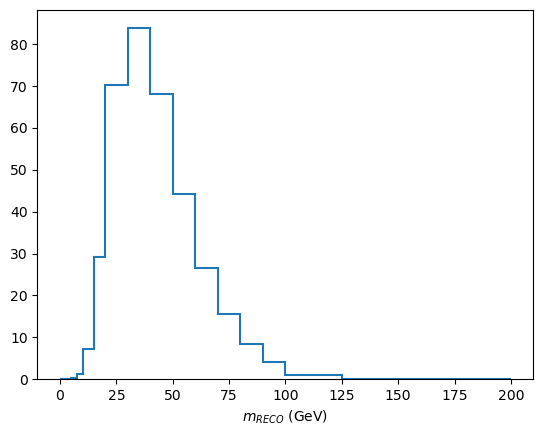

In [28]:
import hist
out['ptjet_mjet_u_reco'].project("ptreco", "mreco")[0,:hist.loc(200)].plot(binwnorm = True)


In [35]:
out['ptjet_mjet_u_reco'][{"systematic":"nominal"}].project('ptreco').values(flow = True)


array([78529.76711184, 84140.27209741, 18660.78423964,  7355.72819446,
           0.        ])

In [36]:
out['response_matrix_u'][{"systematic":"nominal"}].project('ptgen','ptreco').values(flow = True)[1:, :].sum(axis = 0)

array([ 6062.31429327, 56209.10033578, 18374.44085071,  7246.94942245,
           0.        ])

In [37]:
h1 = out['ptjet_mjet_u_reco'][{"systematic":"nominal"}].project('ptreco','mreco')[2,hist.rebin(1)]
h1.sum()

WeightedSum(value=7355.73, variance=199.839)

(0.0, 200.0)

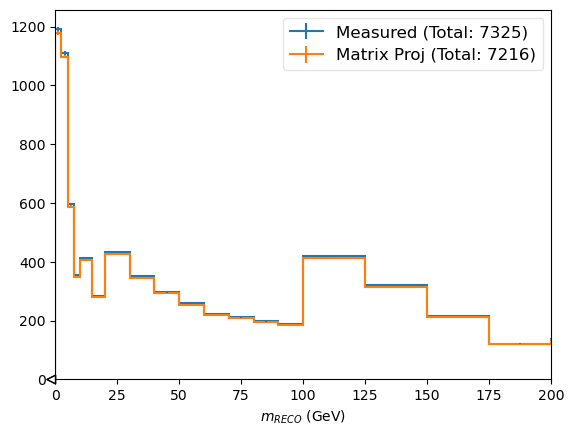

In [38]:
import hist
import matplotlib.pyplot as plt
h1 = out['ptjet_mjet_g_reco'][{"systematic":"nominal"}].project('ptreco','mreco')[2,hist.rebin(1)]
h2 = out['response_matrix_g'][{"systematic":"nominal"}].project('ptreco','mreco')[2,hist.rebin(1)]
h1.plot(label='Measured')
h2.plot(label='Matrix Proj')
plt.legend()
total_reco = h1.sum().value
total_gen = h2.sum().value
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
new_labels = []
for lab in labels:
    if lab == 'Measured':
        new_labels.append(f"Measured (Total: {total_reco:.0f})")
    elif lab == 'Matrix Proj':
        new_labels.append(f"Matrix Proj (Total: {total_gen:.0f})")
    else:
        new_labels.append(lab)
ax.legend(handles, new_labels, loc='best', fontsize=12, framealpha=0.5)
#plt.yscale('log')
plt.xlim(0,200)

(0.0, 200.0)

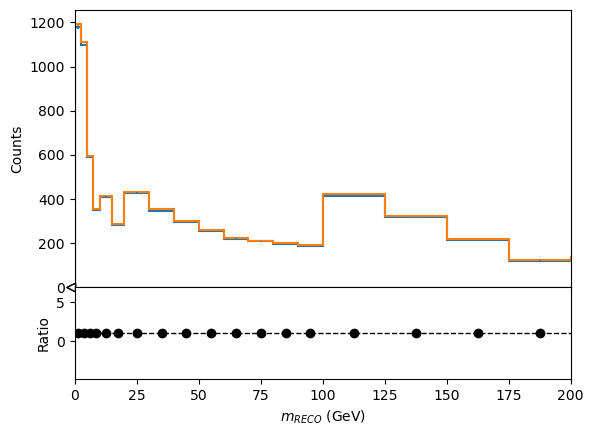

In [39]:
h2.plot_ratio(h1)
plt.xlim(0,200)

(0.0, 200.0)

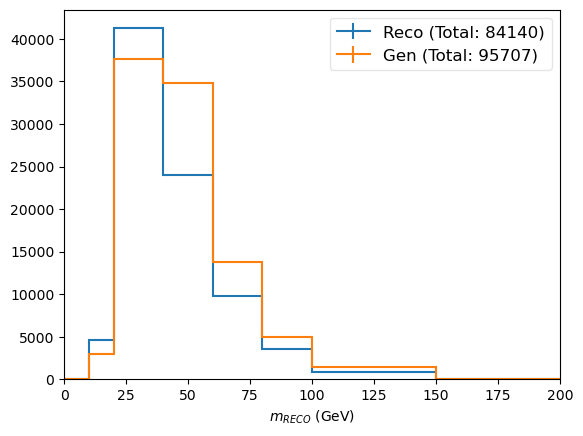

In [40]:
import hist
import matplotlib.pyplot as plt
h1 = out['ptjet_mjet_u_reco'][{"systematic":"nominal"}].project('ptreco','mreco')[0,hist.rebin(2)]
h2 = out['ptjet_mjet_u_gen'][{"systematic":"nominal"}].project('ptgen','mgen')[0,hist.rebin(1)]
h1.plot(label='Reco')
h2.plot(label='Gen')
plt.legend()
total_reco = h1.sum().value
total_gen = h2.sum().value
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
new_labels = []
for lab in labels:
    if lab == 'Reco':
        new_labels.append(f"Reco (Total: {total_reco:.0f})")
    elif lab == 'Gen':
        new_labels.append(f"Gen (Total: {total_gen:.0f})")
    else:
        new_labels.append(lab)
ax.legend(handles, new_labels, loc='best', fontsize=12, framealpha=0.5)
#plt.yscale('log')
plt.xlim(0,200)

(0.0, 200.0)

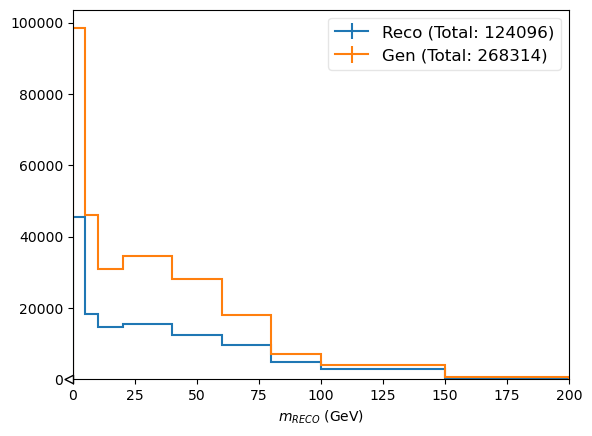

In [41]:
import hist
import matplotlib.pyplot as plt
h1 = out['ptjet_mjet_g_reco'][{"systematic":"nominal"}].project('mreco')[hist.rebin(2)]
h2 = out['ptjet_mjet_g_gen'][{"systematic":"nominal"}].project('mgen')[hist.rebin(1)]
h1.plot(label='Reco')
h2.plot(label='Gen')
plt.legend()
total_reco = h1.sum().value
total_gen = h2.sum().value
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
new_labels = []
for lab in labels:
    if lab == 'Reco':
        new_labels.append(f"Reco (Total: {total_reco:.0f})")
    elif lab == 'Gen':
        new_labels.append(f"Gen (Total: {total_gen:.0f})")
    else:
        new_labels.append(lab)
ax.legend(handles, new_labels, loc='best', fontsize=12, framealpha=0.5)
#plt.yscale('log')
plt.xlim(0,200)

In [42]:
out['response_matrix_g']

Hist(
  StrCategory(['pythia_UL16NanoAODAPVv9_HT-100to200', 'pythia_UL16NanoAODAPVv9_HT-600to800', 'pythia_UL16NanoAODAPVv9_HT-800to1200', 'pythia_UL16NanoAODAPVv9_HT-1200to2500', 'pythia_UL16NanoAODAPVv9_HT-400to600', 'pythia_UL16NanoAODAPVv9_HT-200to400', 'pythia_UL16NanoAODv9_HT-1200to2500', 'pythia_UL16NanoAODv9_HT-2500toInf', 'pythia_UL17NanoAODv9_HT-100to200', 'pythia_UL17NanoAODv9_HT-800to1200', 'pythia_UL17NanoAODv9_HT-2500toInf', 'pythia_UL17NanoAODv9_HT-1200to2500', 'pythia_UL17NanoAODv9_HT-400to600', 'pythia_UL17NanoAODv9_HT-600to800', 'pythia_UL17NanoAODv9_HT-200to400', 'pythia_UL16NanoAODv9_HT-800to1200', 'pythia_UL16NanoAODv9_HT-400to600', 'pythia_UL16NanoAODv9_HT-600to800', 'pythia_UL16NanoAODv9_HT-200to400', 'pythia_UL16NanoAODv9_HT-100to200', 'pythia_UL16NanoAODAPVv9_HT-2500toInf'], growth=True, name='dataset', label='Primary dataset'),
  StrCategory(['ee', 'mm'], growth=True, name='channel', label='Channel'),
  Variable([200, 290, 400, 13000], name='ptreco', label='$p

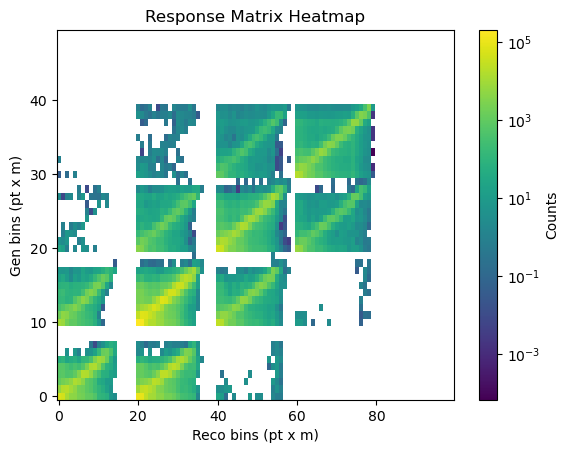

In [44]:
h_resp = out['response_matrix_g'].project('ptgen', 'mgen', 'ptreco', 'mreco')
resp_vals = h_resp.values(flow = True)
resp_vals = resp_vals[:, 1:-1, :, 1:-1] #removing flow from mass
resp_vals_2d = resp_vals.reshape(resp_vals.shape[0]*resp_vals.shape[1], resp_vals.shape[2]*resp_vals.shape[3])
plt.imshow(resp_vals_2d, origin='lower', aspect='auto', cmap='viridis', norm = 'log')
plt.colorbar(label='Counts')
plt.xlabel('Reco bins (pt x m)')
plt.ylabel('Gen bins (pt x m)')
plt.title('Response Matrix Heatmap')
plt.show()

In [39]:
resp_vals.sum(axis= (0,1,3))

array([664213.38099872, 725301.16805286, 155873.00071236,  58887.55901854,
            0.        ])

In [30]:
import pickle
with open("test_output.pkl", "wb") as f:
    pickle.dump(out, f)
print(f"Output written to test_output.pkl with size {os.path.getsize('test_output.pkl')/1e3:.1f} KB")

NameError: name 'out' is not defined

In [118]:
!cp test_output.pkl working.pkl

In [56]:
import pickle
with open('pythia_ht_LO_output.pkl', "wb") as f:
    pickle.dump(out, f)
print(f"Output written to test_output.pkl with size {os.path.getsize('pythia_ht_LO_output.pkl')/1e6:.1f} MB")


Output written to test_output.pkl with size 229.5 MB
